# __PIXDIMS__

## Imports & config

In [1]:
%load_ext autoreload
%autoreload 2
import os
os.chdir('C:\\Users\\Usuario\\TFG\\digipanca\\')

In [29]:
import nibabel as nib
import numpy as np
from scipy.ndimage import zoom
import matplotlib.pyplot as plt

## __Check pixdims__

In [8]:
DATA_DIR = 'data/raw/train'
PATIENT_IDS = [p for p in os.listdir(DATA_DIR)]

### _Load NIfTIs and save pixdims_

In [10]:
PIXDIMS = []

for pid in PATIENT_IDS:
    image_path = os.path.join(DATA_DIR, pid, "SEQ", f"CTport-{pid}.nii")
    image = nib.load(image_path)
    PIXDIMS.append(image.header.get_zooms())

### _Analyse pixdims_

In [17]:
pixdims = np.array(PIXDIMS)
print(f"Mean (x, y, z): {pixdims.mean(axis=0)}")
print(f"Median (x, y, z): {np.median(pixdims, axis=0)}")
print(f"Min (x, y, z): {pixdims.min(axis=0)}")
print(f"Max (x, y, z): {pixdims.max(axis=0)}")

Mean (x, y, z): [0.82715946 0.82715946 1.2818657 ]
Median (x, y, z): [0.8095703 0.8095703 1.017523 ]
Min (x, y, z): [0.65351564 0.65351564 0.99999994]
Max (x, y, z): [1.0230937 1.0230937 2.5555556]


## __Check slices__

In [12]:
SLICES = []

for pid in PATIENT_IDS:
    image_path = os.path.join(DATA_DIR, pid, "SEQ", f"CTport-{pid}.nii")
    image = nib.load(image_path)
    SLICES.append(image.shape[2])

### _Analyse slices and pixdims_

In [15]:
for patient_id, pixdim, slices in zip(PATIENT_IDS, PIXDIMS, SLICES):
    print(f"Patient {patient_id}: {pixdim[2]:.3f} mm, {slices} slices = {pixdim[2] * slices}")

Patient rtum1: 1.011 mm, 91 slices = 91.98913562297821
Patient rtum10: 2.000 mm, 56 slices = 112.0
Patient rtum11: 1.000 mm, 104 slices = 104.0
Patient rtum12: 1.515 mm, 68 slices = 103.0149245262146
Patient rtum13: 2.000 mm, 67 slices = 134.0
Patient rtum14: 1.000 mm, 125 slices = 125.00010430812836
Patient rtum15: 1.000 mm, 120 slices = 120.0
Patient rtum16: 1.018 mm, 114 slices = 116.05405282974243
Patient rtum17: 1.019 mm, 108 slices = 110.01868629455566
Patient rtum18: 1.019 mm, 104 slices = 106.01942253112793
Patient rtum19: 1.000 mm, 91 slices = 91.0
Patient rtum2: 1.281 mm, 90 slices = 115.29876708984375
Patient rtum20: 2.500 mm, 44 slices = 110.0
Patient rtum21: 1.017 mm, 116 slices = 118.0172553062439
Patient rtum22: 1.000 mm, 117 slices = 117.0
Patient rtum23: 1.020 mm, 105 slices = 107.07920730113983
Patient rtum24: 1.005 mm, 101 slices = 101.52061557769775
Patient rtum25: 1.039 mm, 105 slices = 109.11764681339264
Patient rtum26: 1.018 mm, 116 slices = 118.04795408248901
Pa

## __Resampling (spacing)__

### _Function_

In [21]:
def spacing_3d(image_nii, mask_nii=None, target_spacing=(1.,1.,1.)):
    # 1. Original spacing
    orig_spacing = image_nii.header.get_zooms()[:3]
    # 2. Zoom factors for scipy.zoom
    factors = np.array(orig_spacing) / np.array(target_spacing)
    # 3. Data
    img = image_nii.get_fdata()
    img_res = zoom(img, factors, order=1) # lineal

    msk_res = None
    if mask_nii is not None:
        msk = mask_nii.get_fdata()
        msk_res = zoom(msk, factors, order=0) # nearest

    # 4. Affine
    new_affine = image_nii.affine.copy()
    new_affine[0,0] = target_spacing[0]
    new_affine[1,1] = target_spacing[1]
    new_affine[2,2] = target_spacing[2]

    return img_res, msk_res, new_affine

### _Apply resampling_

In [26]:
SHAPES_RES = []

for pid in PATIENT_IDS[:10]:
    print(f"Resampling {pid}")
    image_path = os.path.join(DATA_DIR, pid, "SEQ", f"CTport-{pid}.nii")
    image = nib.load(image_path)
    image, _, new_affine = spacing_3d(image_nii=image, target_spacing=(0.8, 0.8, 1.2))
    SHAPES_RES.append(image.shape)    

Resampling rtum1
Resampling rtum10
Resampling rtum11
Resampling rtum12
Resampling rtum13
Resampling rtum14
Resampling rtum15
Resampling rtum16
Resampling rtum17
Resampling rtum18


In [27]:
for patient_id, shape in zip(PATIENT_IDS[:10], SHAPES_RES):
    print(f"Patient {patient_id}: {shape}")

Patient rtum1: (480, 480, 77)
Patient rtum10: (454, 454, 93)
Patient rtum11: (501, 501, 87)
Patient rtum12: (490, 490, 86)
Patient rtum13: (584, 584, 112)
Patient rtum14: (502, 502, 104)
Patient rtum15: (516, 516, 100)
Patient rtum16: (512, 512, 97)
Patient rtum17: (625, 625, 92)
Patient rtum18: (418, 418, 88)


### _Visualize_

In [41]:
IMAGES = []
IMAGES_RES = []

for pid in PATIENT_IDS[:10]:
    print(f"Resampling {pid}")
    image_path = os.path.join(DATA_DIR, pid, "SEQ", f"CTport-{pid}.nii")
    image = nib.load(image_path)
    image_res, _, new_affine = spacing_3d(image_nii=image, target_spacing=(0.8, 0.8, 1.))
    IMAGES.append(image.get_fdata()[:,:,0])
    IMAGES_RES.append(image_res[:,:,0])

Resampling rtum1
Resampling rtum10
Resampling rtum11
Resampling rtum12
Resampling rtum13
Resampling rtum14
Resampling rtum15
Resampling rtum16
Resampling rtum17
Resampling rtum18


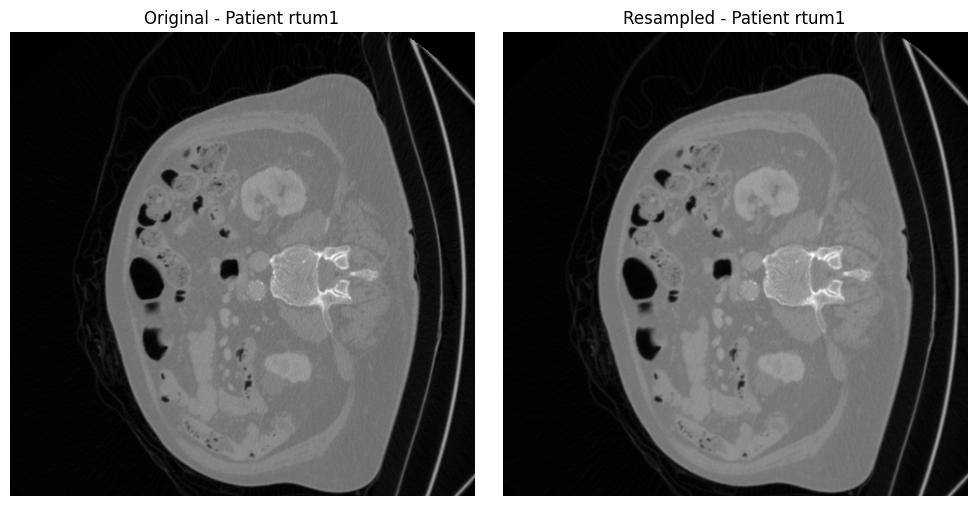

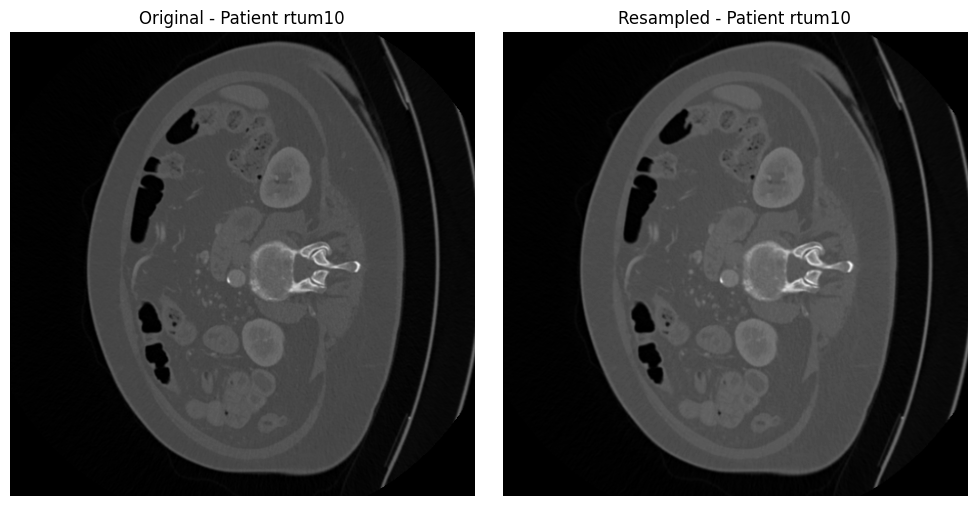

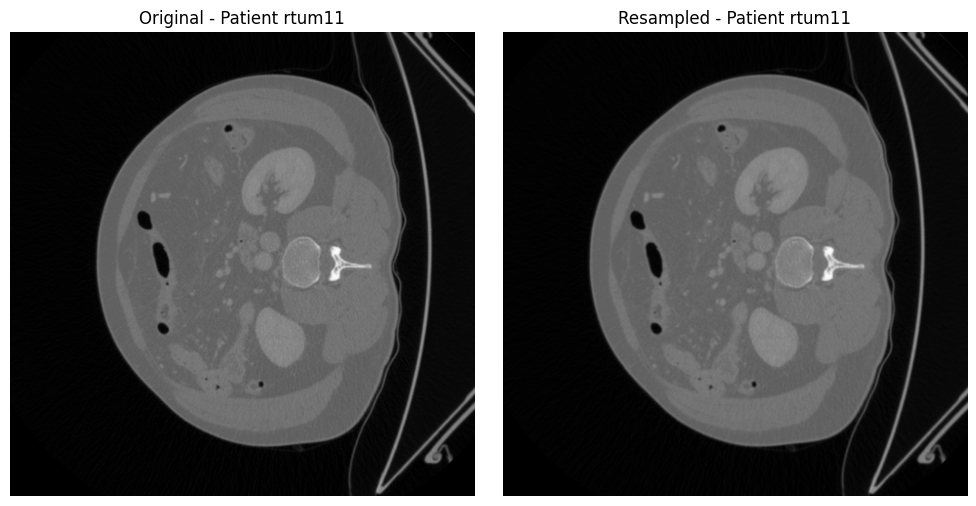

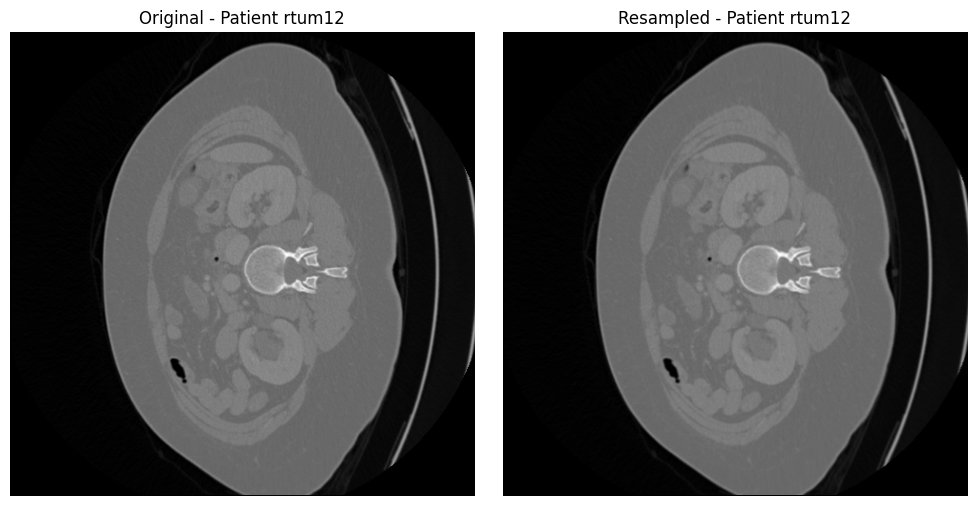

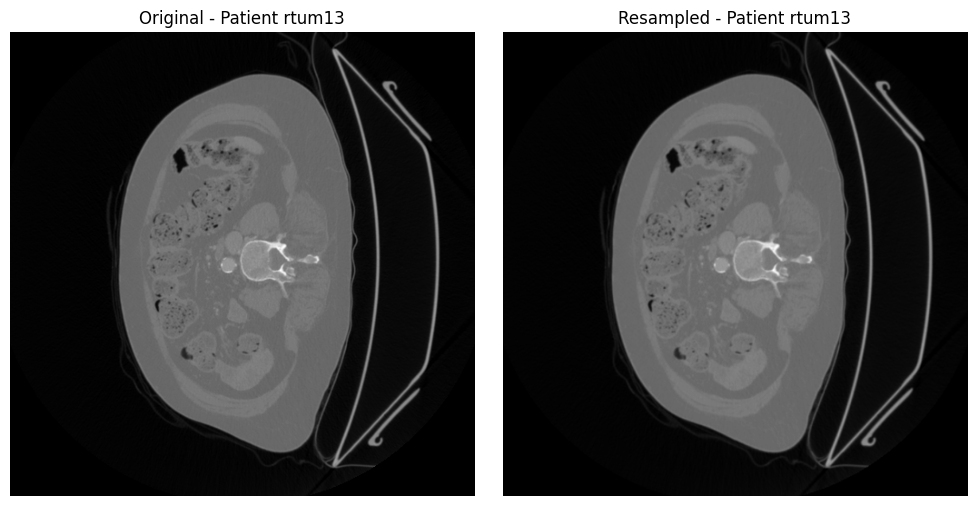

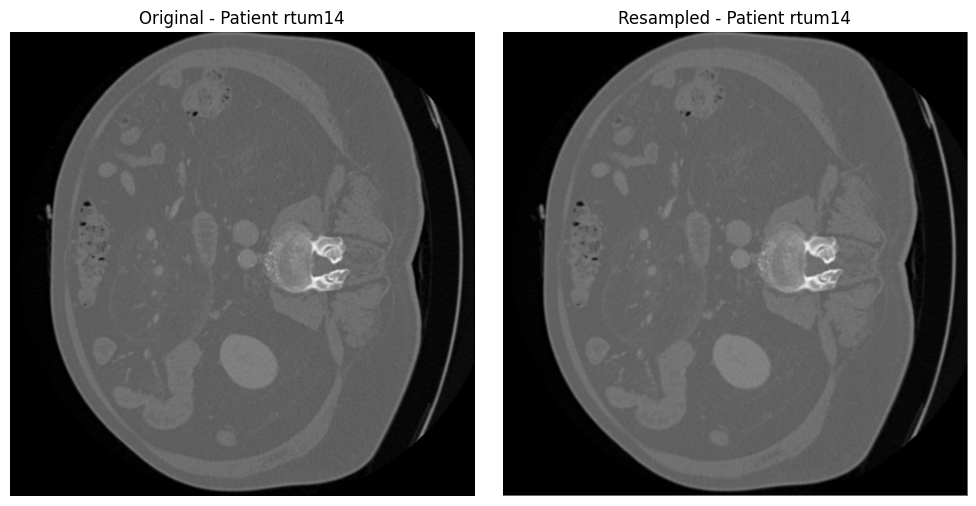

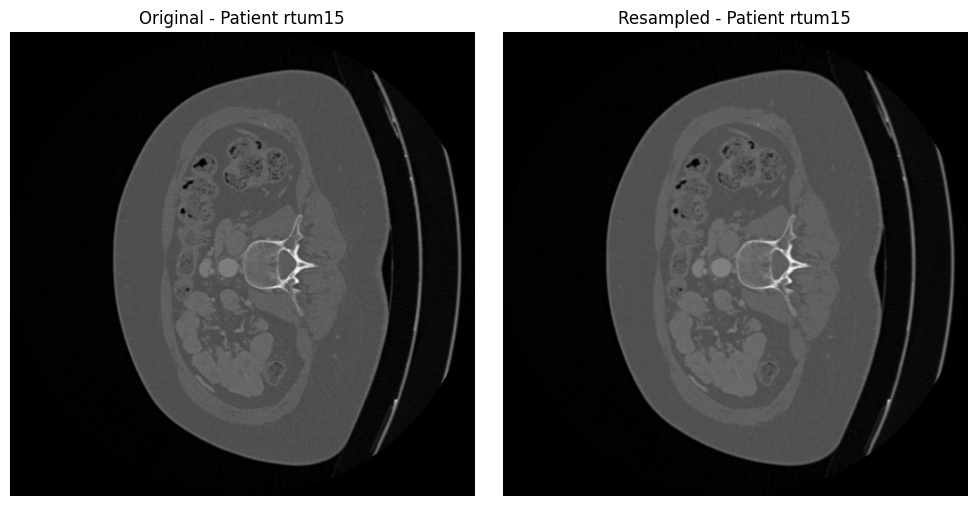

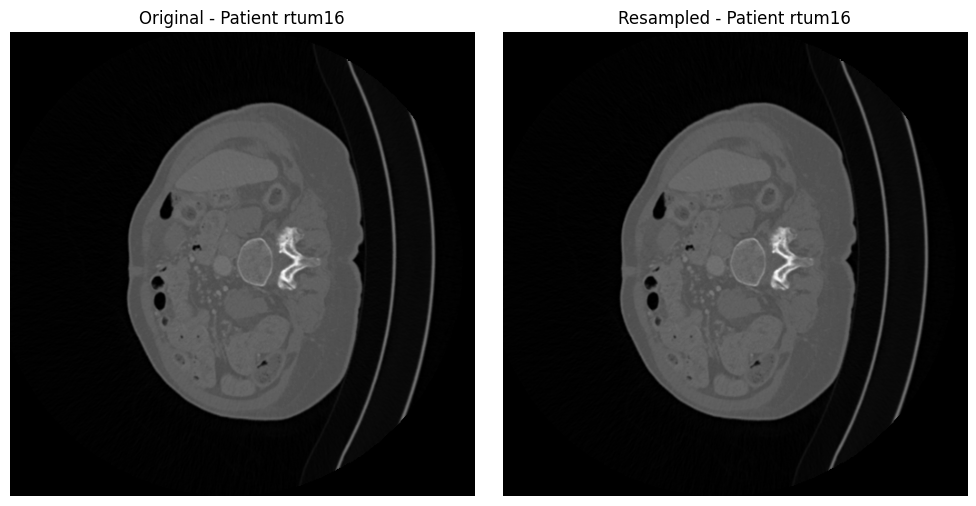

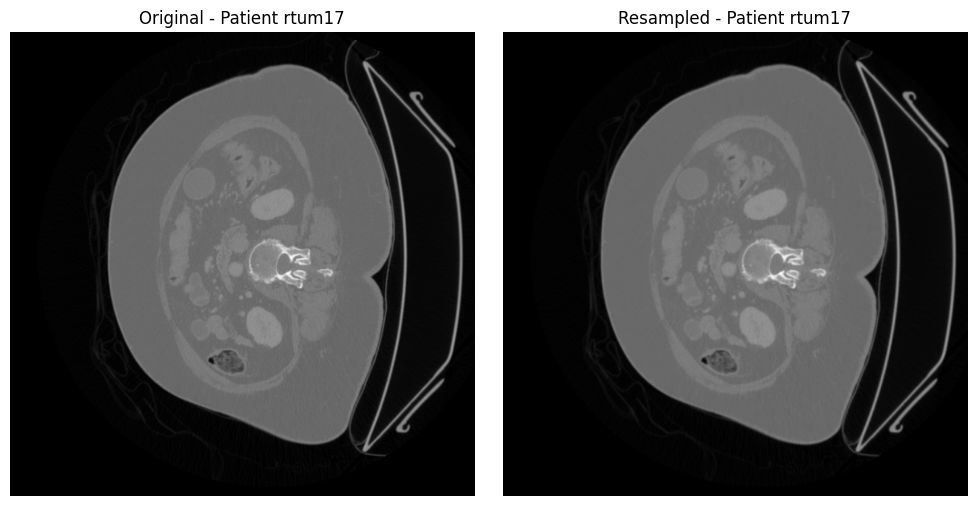

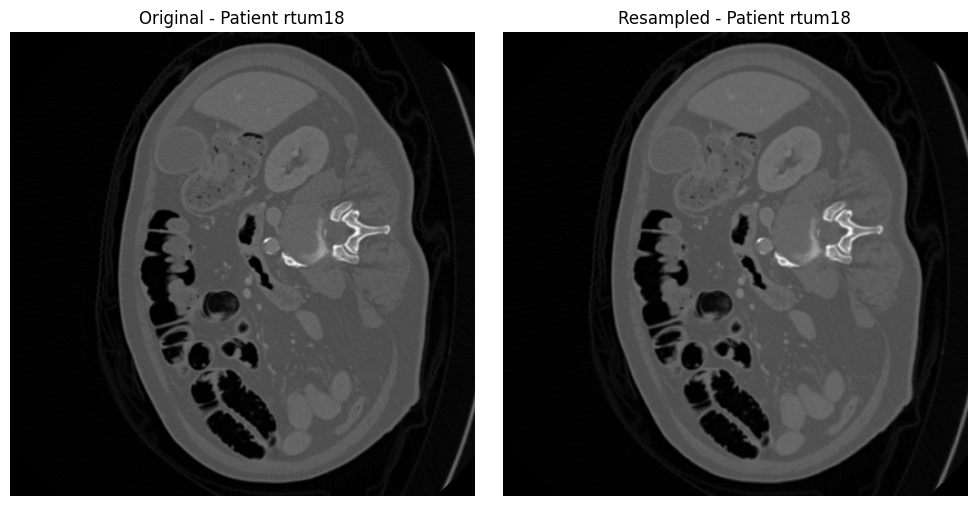

In [43]:
for idx, (img_orig, img_res) in enumerate(zip(IMAGES, IMAGES_RES)):
    plt.figure(figsize=(10, 5))
    
    # Original
    plt.subplot(1, 2, 1)
    plt.imshow(img_orig, cmap='gray')
    plt.title(f'Original - Patient {PATIENT_IDS[idx]}')
    plt.axis('off')
    
    # Resampled
    plt.subplot(1, 2, 2)
    plt.imshow(img_res, cmap='gray')
    plt.title(f'Resampled - Patient {PATIENT_IDS[idx]}')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [38]:
def resize_image(image, target_height, target_width):
    """
    Recorta o añade padding a una imagen 2D (Hi, Wi) o 3D (Hi, Wi, Di) para que tenga
    (H, W) o (H, W, Di) respectivamente, manteniendo la profundidad si existe.
    
    Args:
        image (np.ndarray): Imagen 2D o 3D de entrada.
        target_height (int): Altura objetivo (H).
        target_width (int): Ancho objetivo (W).
        
    Returns:
        np.ndarray: Imagen redimensionada.
    """
    # Asegurar que trabajamos en 3D para simplificar
    if image.ndim == 2:
        image = image[:, :, np.newaxis]  # Convertir a (Hi, Wi, 1)

    Hi, Wi, Di = image.shape

    # --- Recorte si es más grande ---
    if Hi > target_height:
        start_i = (Hi - target_height) // 2
        end_i = start_i + target_height
    else:
        start_i = 0
        end_i = Hi

    if Wi > target_width:
        start_j = (Wi - target_width) // 2
        end_j = start_j + target_width
    else:
        start_j = 0
        end_j = Wi

    image_cropped = image[start_i:end_i, start_j:end_j, :]

    # --- Padding si es más pequeño ---
    Hi_c, Wi_c, _ = image_cropped.shape
    pad_h = target_height - Hi_c
    pad_w = target_width - Wi_c

    pad_h_before = pad_h // 2
    pad_h_after = pad_h - pad_h_before
    pad_w_before = pad_w // 2
    pad_w_after = pad_w - pad_w_before

    padding = (
        (pad_h_before, pad_h_after),
        (pad_w_before, pad_w_after),
        (0, 0)  # No padding en profundidad
    )

    image_padded = np.pad(image_cropped, padding, mode='constant', constant_values=0)

    # Si originalmente era 2D, devolver 2D
    if image_padded.shape[2] == 1:
        image_padded = np.squeeze(image_padded, axis=2)

    return image_padded

Patient rtum1: original (512, 512), resampled (480, 480)


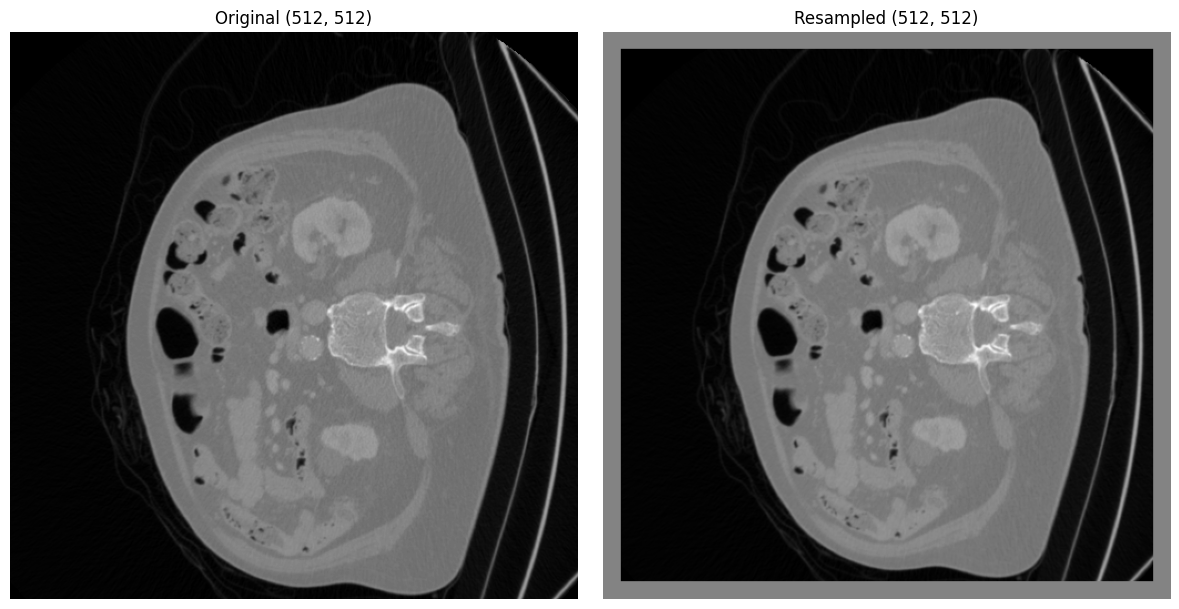

Patient rtum10: original (512, 512), resampled (454, 454)


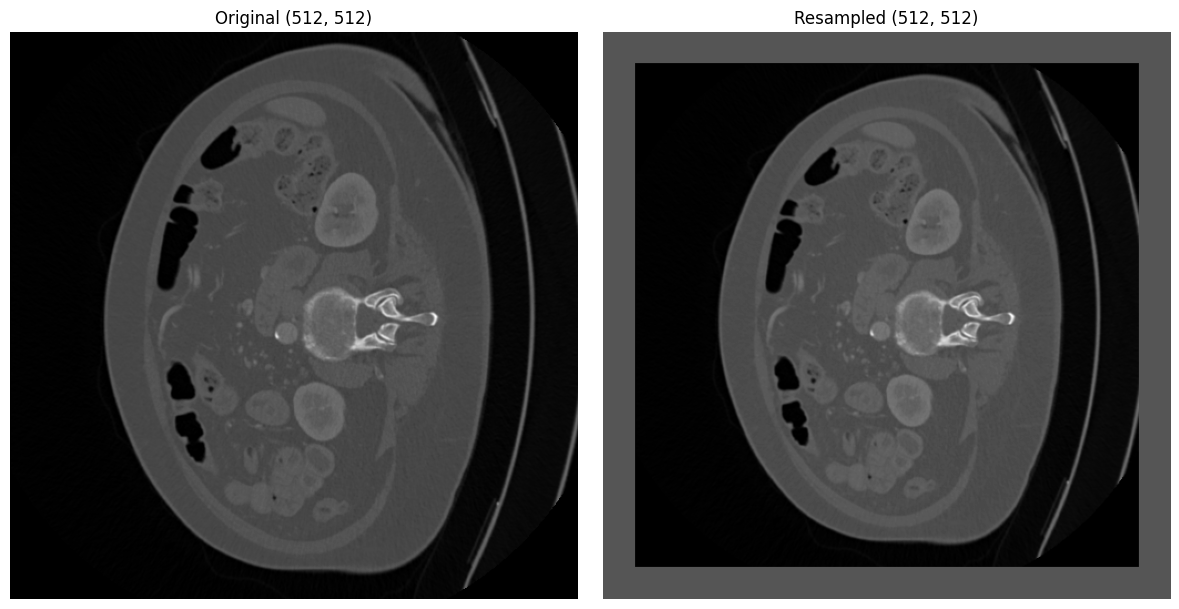

Patient rtum11: original (512, 512), resampled (501, 501)


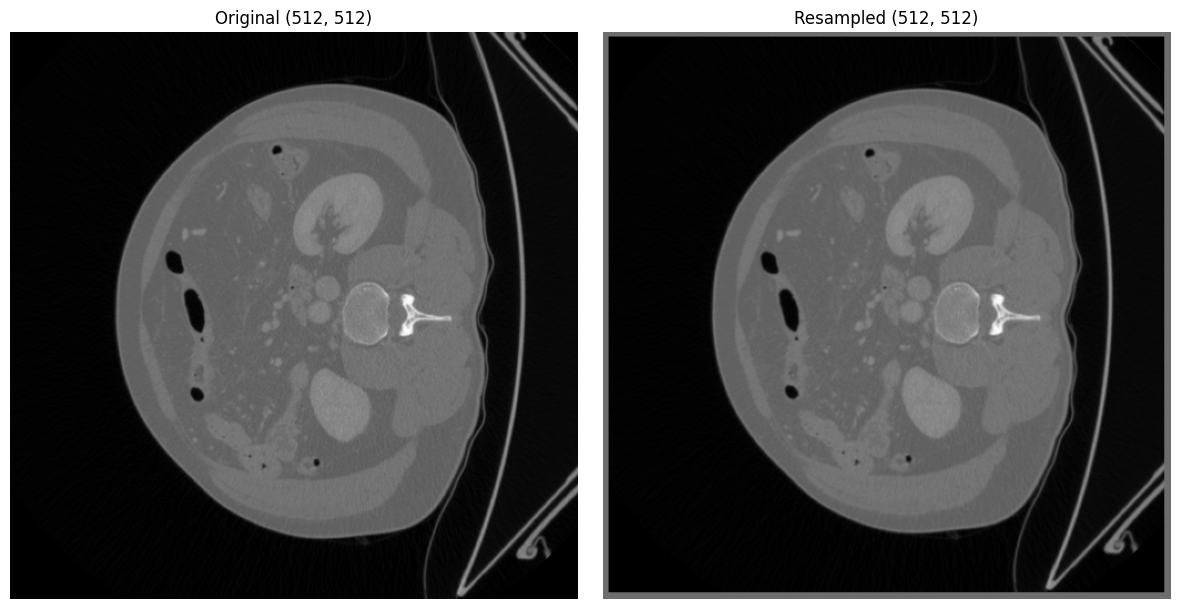

Patient rtum12: original (512, 512), resampled (490, 490)


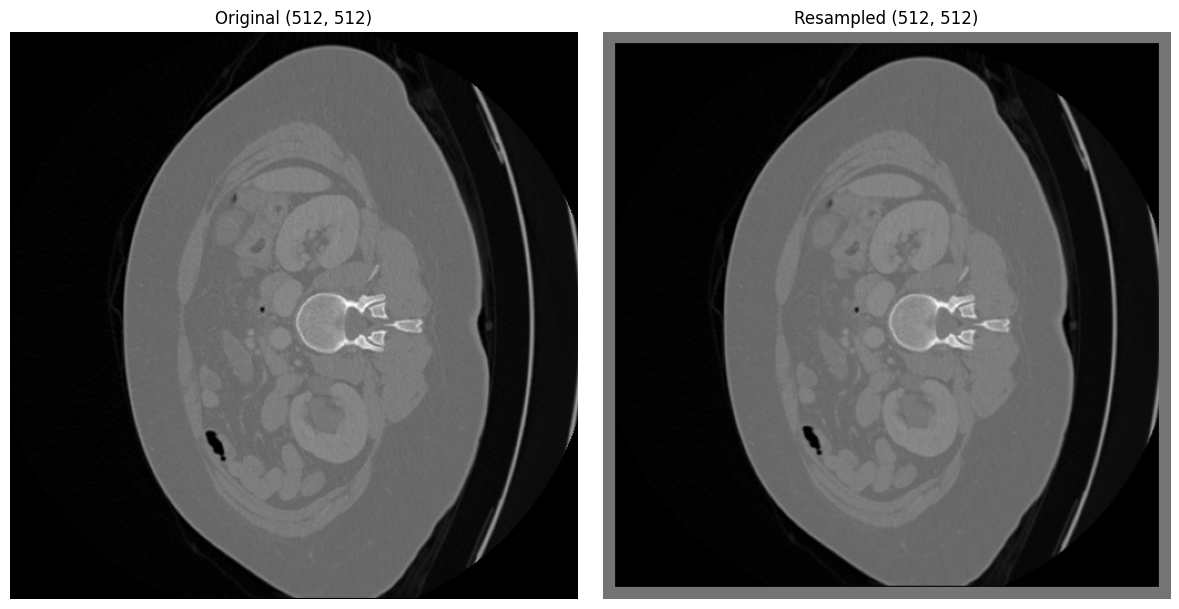

Patient rtum13: original (512, 512), resampled (584, 584)


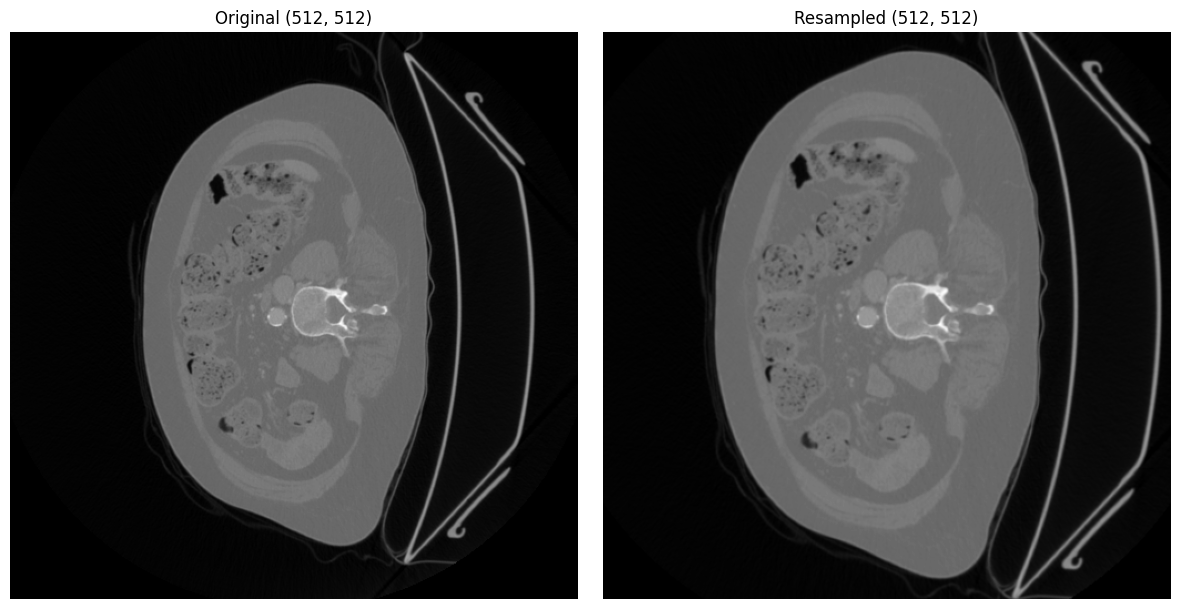

Patient rtum14: original (512, 512), resampled (502, 502)


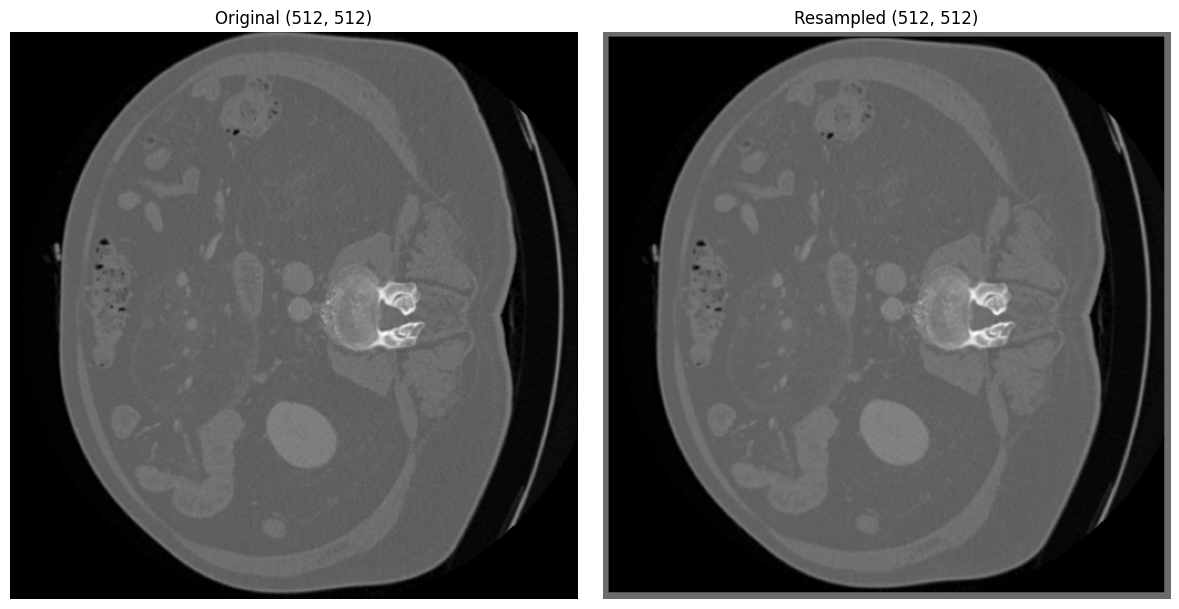

Patient rtum15: original (512, 512), resampled (516, 516)


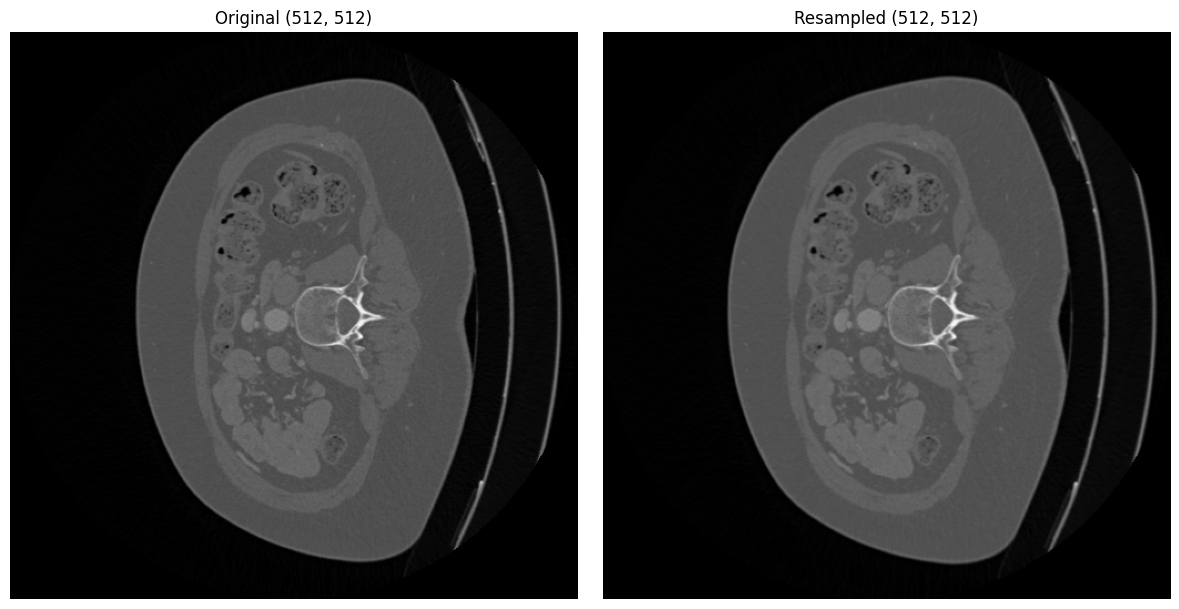

Patient rtum16: original (512, 512), resampled (512, 512)


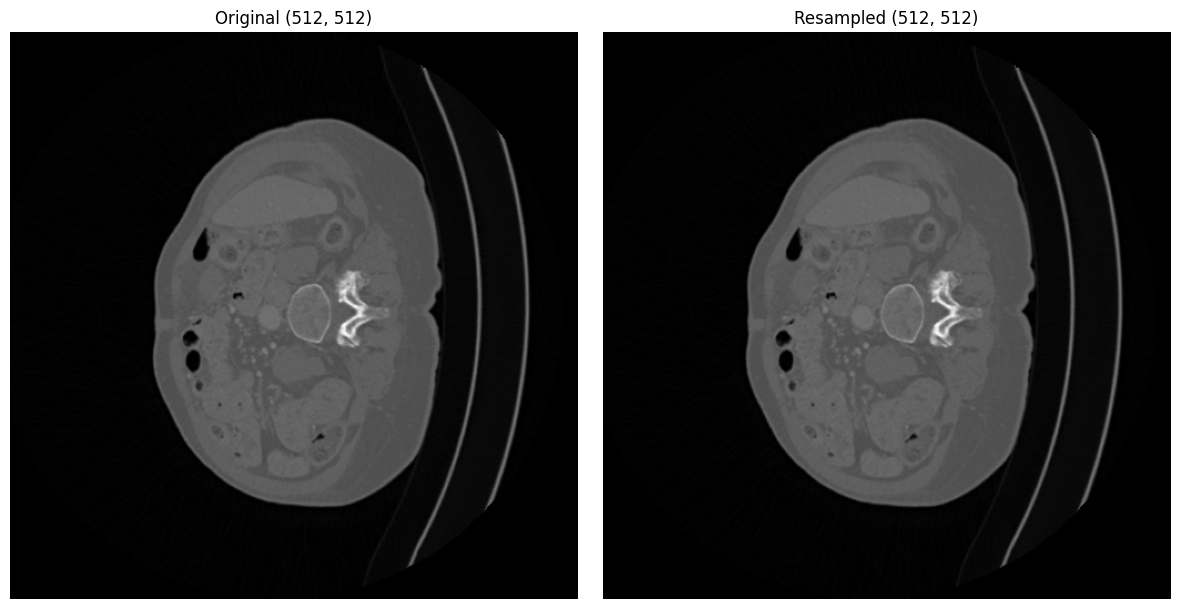

Patient rtum17: original (512, 512), resampled (625, 625)


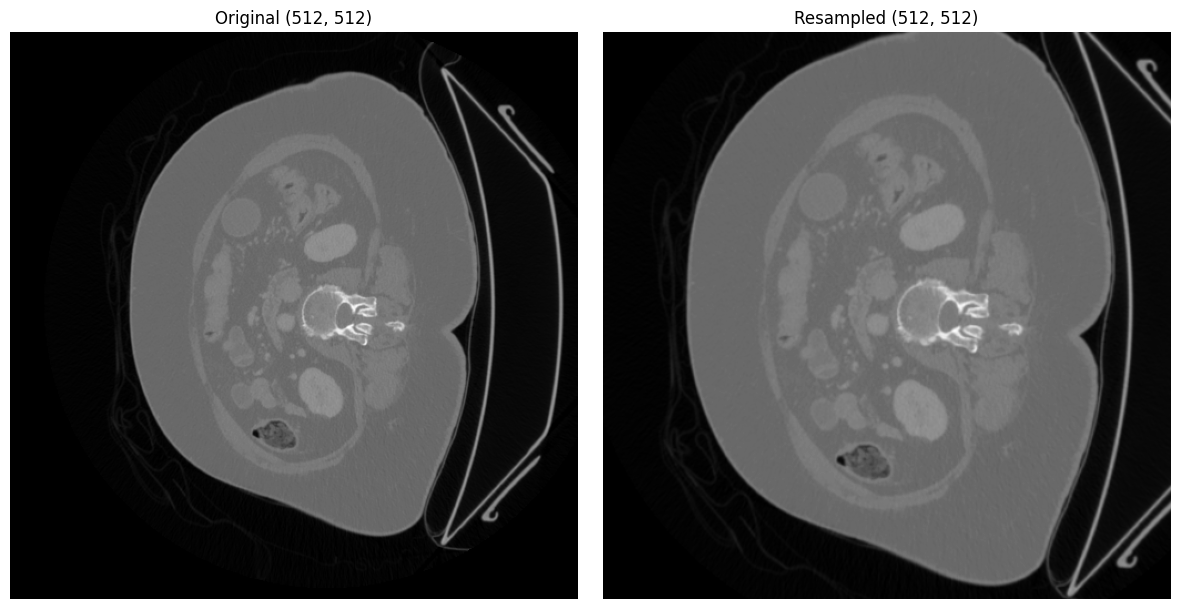

Patient rtum18: original (512, 512), resampled (418, 418)


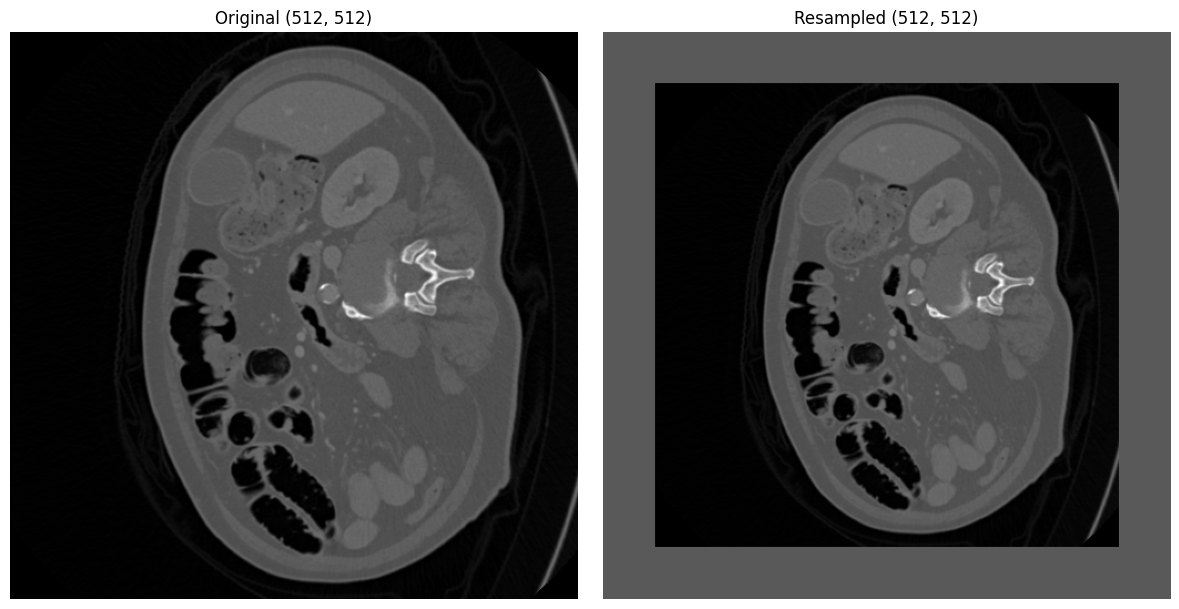

In [44]:
for idx, (img_orig, img_res) in enumerate(zip(IMAGES, IMAGES_RES)):
    print(f"Patient {PATIENT_IDS[idx]}: original {img_orig.shape}, resampled {img_res.shape}")
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Original
    axes[0].imshow(img_orig, cmap='gray')
    axes[0].set_title(f'Original {img_orig.shape}')
    axes[0].axis('off')

    # Resampled
    img_res = resize_image(img_res, 512, 512)
    axes[1].imshow(img_res, cmap='gray')
    axes[1].set_title(f'Resampled {img_res.shape}')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()